In [1]:
import sys
sys.path.append('scripts/')
from FPLmaker_arr_only import *
from graph import *
from importlib import reload # >= python 3.4


seed = 303
random.seed(seed)


#2024/1/29　修正　delayの与え方を変更: delay = t→t+1

In [8]:
class RUATM:                                                                                            #UATM 0=A 1=B 2=C 3=D
    def __init__(self, airspace_max):
        self.airspace_max = airspace_max             #  10, 10, 10, 10
        
    
class DCB:
    def __init__(self, airspace_max): #DCBを行う関数
        self.airspace_max = airspace_max
        self.total_delay = np.zeros(4) #総遅延時間
        self.num_delay = np.zeros((0, 4))
    
    
    
    def centralized_fcfs(self, ruatm_id, capacity, sim_time, bin_data, bin_size, fpl):  #全部の情報がわかる状態。中央制御的にやる。
        self.ruatm_id = ruatm_id #ruatm_id = 0, 1, 2
        self.capacity = capacity
        self.sim_time = sim_time
        self.bin_data = bin_data
        self.bin_size = bin_size
        self.fpl = fpl.copy()
        self.delay_memo = np.zeros((0, len(ruatm_id)*2))
        
        
        for i in range(len(self.bin_data)):  #binをループ
            if np.sum(self.bin_data[i]) > self.capacity:  #キャパを超えてるか確認
                self.bin_start_time = self.bin_size * i  #binの開始時刻
                self.bin_end_time = self.bin_size*(i+1)  #binの終了時刻
                self.arr_fpl = self.fpl[(self.bin_start_time < self.fpl['arr_time']) 
                                           & (self.fpl['arr_time'] < self.bin_end_time)] #ビン該当の時刻に到着するフライトを抽出
                self.arr_fpl = self.arr_fpl.sort_values('arr_time', ascending=False)  #到着の遅い順にソート
                
                print(np.sum(self.bin_data[i]) - self.capacity)
                #print(self.bin_start_time/60, self.bin_end_time/60, self.arr_fpl)
                
                self.change_count = 0 #出発変更した機体の数カウントする
                for j in self.arr_fpl['flight_id']: #該当フライトを遅い順に反復
                    if self.change_count >= np.sum(self.bin_data[i]) - self.capacity: break #変更指示数がオーバー数を超えたら終了
                    #if any(i == self.over_flight_id) == False: continue #ownRUATM出発で、現在capacityにかかわっていないものは省く
                    
                    delay = -1 + self.bin_size + self.bin_end_time - self.fpl.at[j, 'arr_time'] #次のbin 終了時刻 - 当該フライトの出発時刻 + 1 ここ注意！！！！！！！！！！！！！
                    self.fpl.at[j, 'dep_time'] += delay  #出発時刻をdelayだけ遅らせる
                    self.fpl.at[j, 'arr_time'] += delay  #到着時刻をdelayだけ遅らせる
                    
                    #メモ用
                    apd_delay = np.zeros(len(ruatm_id)*2)
                    apd_delay[3:6] = np.nan
                    apd_delay[self.fpl.at[j, 'dep']] = delay
                    apd_delay[self.fpl.at[j, 'dep']+3] = j
                    if np.any(self.delay_memo[:, self.fpl.at[j, 'dep']+3] == j):
                        self.delay_memo[np.where(self.delay_memo[:, self.fpl.at[j, 'dep']+3] == j)[0], self.fpl.at[j, 'dep']] += delay
                    else:
                        self.delay_memo = np.append(self.delay_memo, apd_delay.reshape(1, len(ruatm_id)*2), axis=0)
                    self.change_count += 1
            
                delayed_ac = ArrCheck(self.fpl, len(ruatm_id), route, self.sim_time)
                delayed_vport_flight_data, delayed_vport_ruatm_data = delayed_ac.flight(flight_num)
                self.bin_data = delayed_ac.demand_calc(delayed_vport_ruatm_data, bin_size)
        
        self.delay_summary = np.zeros(len(ruatm_id)*3)
        self.delay_summary[:] = np.nan
        self.delay_summary[0:3] = np.sum(self.delay_memo, axis=0)[0:3]  # 0,1,2は合計
        self.delay_summary[3:6] = np.max(self.delay_memo, axis=0)[0:3]  # 3,4,5は最大値
        self.delay_summary[6] = len(np.unique(self.delay_memo[:, 3])) -1
        self.delay_summary[7] = len(np.unique(self.delay_memo[:, 4])) -1
        self.delay_summary[8] = len(np.unique(self.delay_memo[:, 5])) -1
        #self.delay_memo = np.append(self.delay_memo, np.sum(dcb.delay_memo, axis=0).reshape(1, len(ruatm_id)+1), axis=0) #delayの合計
        #self.delay_memo[-1, -1] = len(np.unique(self.delay_memo[:, -1])) -1
        
        return self.fpl, self.bin_data
    
    
    
    
    def distributed_fcfs(self, ruatm_id, capacity, sim_time, bin_data, bin_size, fpl):  #分散型。ほかのRUATMの情報尾は全くわからない
        self.ruatm_id = ruatm_id # ruatm_id = one of them
        self.capacity = capacity # = 1
        self.sim_time = sim_time
        self.bin_data = bin_data
        self.bin_size = bin_size # 9
        self.fpl = fpl.copy()
        self.ruatm_num = 3
        self.delay_memo = np.zeros((0, 2))
        apd_delay = np.zeros(2)
        
        
        for i in range(len(self.bin_data)):  #binをループ
            if self.bin_data[i, self.ruatm_id] > self.capacity:  #キャパを超えてるか確認
                self.bin_start_time = self.bin_size * i  #binの開始時刻
                self.bin_end_time = self.bin_size*(i+1)  #binの終了時刻
                self.arr_fpl = self.fpl[(self.bin_start_time < self.fpl['arr_time']) 
                                           & (self.fpl['arr_time'] < self.bin_end_time)] #ビン該当の時刻に到着するフライトを抽出
                self.arr_fpl = self.arr_fpl.sort_values('arr_time', ascending=False)  #到着の遅い順にソート
                
                print(self.bin_data[i, self.ruatm_id] - self.capacity)
                #print(self.bin_start_time/60, self.bin_end_time/60, self.arr_fpl)
                
                self.change_count = 0 #出発変更した機体の数カウントする
                
                for j in self.arr_fpl['flight_id']: #該当フライトを遅い順に反復
                    if self.change_count >= self.bin_data[i, self.ruatm_id] - self.capacity: break #変更指示数がオーバー数を超えたら終了
                    if self.arr_fpl.at[j, 'dep'] != self.ruatm_id: continue #該当ruatmの機体じゃなかったらスキップ
                        
                    delay = -1 + self.bin_size + self.bin_end_time - self.fpl.at[j, 'arr_time'] #次のbin 終了時刻 - 当該フライトの出発時刻 + 1 ここ注意！！！！！！！！！！！！！
                    self.fpl.at[j, 'dep_time'] += delay  #出発時刻をdelayだけ遅らせる
                    self.fpl.at[j, 'arr_time'] += delay  #到着時刻をdelayだけ遅らせる
                    
                    #メモ用
                    apd_delay = np.zeros(2)
                    apd_delay[0] = delay
                    apd_delay[-1] = j
                    if np.any(self.delay_memo[:, -1] == j):
                        self.delay_memo[np.where(self.delay_memo[:, -1] == j)[0], 0] += delay
                    else:
                        self.delay_memo = np.append(self.delay_memo, apd_delay.reshape(1, 2), axis=0)
                    self.change_count += 1
            
                delayed_ac = ArrCheck(self.fpl, self.ruatm_num, self.sim_time)
                delayed_vport_flight_data, delayed_vport_ruatm_data = delayed_ac.flight(flight_num)
                self.bin_data = delayed_ac.demand_calc(delayed_vport_ruatm_data, bin_size)
        
        
        if len(self.delay_memo) == 0:
            self.delay_memo = np.zeros((1, 2))
        self.delay_summary = np.zeros(3)
        self.delay_summary[0] = np.sum(self.delay_memo, axis=0)[0]  # 0は合計
        self.delay_summary[1] = np.max(self.delay_memo, axis=0)[0]  # 1は最大値
        self.delay_summary[2] = len(np.unique(self.delay_memo[:, -1]))
        
        #self.delay_memo = np.append(self.delay_memo, np.sum(dcb.delay_memo, axis=0).reshape(1, 2), axis=0)
        #self.delay_memo[-1, -1] = len(np.unique(self.delay_memo[:, -1])) -1
        return self.fpl, self.bin_data
    
    
    
    
    
    
    def cooperative1_fcfs(self, ruatm_id, capacity, route_num, sim_time, bin_data, bin_size, fpl):  #協調分散型。route0,3,6の情報のみ共有される。
        self.ruatm_id = ruatm_id #ruatm_id = 0, 1, 2
        self.capacity = capacity
        self.route_num = route_num
        self.sim_time = sim_time
        self.bin_data = bin_data
        self.bin_size = bin_size
        self.fpl = fpl.copy()
        self.delay_memo = np.zeros((0, len(ruatm_id)*2))
        
        #情報共有されるルートのFPLだけに絞る
        self.cooperative_fpl = self.fpl[(self.fpl['route'] == 0) | (self.fpl['route'] == 3) | (self.fpl['route'] == 6) |
                                       (self.fpl['route'] == 1) | (self.fpl['route'] == 4) | (self.fpl['route'] == 7)]
        #self.cooperative_fpl = self.fpl[(self.fpl['route'] == 0) | (self.fpl['route'] == 3) | (self.fpl['route'] == 6)]
        #self.cooperative_fpl = self.cooperative_fpl.reset_index(drop=True)
        print(self.cooperative_fpl)
                                
        delayed_ac = ArrCheck(self.fpl, len(ruatm_id), route, self.sim_time)
        delayed_vport_flight_data, delayed_vport_ruatm_data = delayed_ac.flight(len(self.fpl))
        self.bin_data = delayed_ac.demand_calc(delayed_vport_ruatm_data, bin_size)
        
        
        for i in range(len(self.bin_data)):  #binをループ
            if np.sum(self.bin_data[i]) > self.capacity:  #キャパを超えてるか確認
                
                self.bin_start_time = self.bin_size * i  #binの開始時刻
                self.bin_end_time = self.bin_size*(i+1)  #binの終了時刻
                self.arr_fpl = self.cooperative_fpl[(self.bin_start_time < self.cooperative_fpl['arr_time']) 
                                           & (self.cooperative_fpl['arr_time'] < self.bin_end_time)] #ビン該当の時刻に到着するフライトを抽出
                self.arr_fpl = self.arr_fpl.sort_values('arr_time', ascending=False)  #到着の遅い順にソート
                
                print(np.sum(self.bin_data[i]) - self.capacity)
                #print(self.bin_start_time/60, self.bin_end_time/60, self.arr_fpl)
                
                self.change_count = 0 #出発変更した機体の数カウントする
                for j in self.arr_fpl['flight_id']: #該当フライトを遅い順に反復
                    if self.change_count >= np.sum(self.bin_data[i]) - self.capacity: break #変更指示数がオーバー数を超えたら終了
                    #if any(i == self.over_flight_id) == False: continue #ownRUATM出発で、現在capacityにかかわっていないものは省く
                    delay = -1 + self.bin_size + self.bin_end_time - self.cooperative_fpl.at[j, 'arr_time'] #次のbin 終了時刻 - 当該フライトの出発時刻 + 1 ここ注意！！！！！！！！！！！！！
                    self.cooperative_fpl.at[j, 'dep_time'] += delay  #出発時刻をdelayだけ遅らせる
                    self.cooperative_fpl.at[j, 'arr_time'] += delay  #到着時刻をdelayだけ遅らせる
                    
                    #メモ用
                    apd_delay = np.zeros(len(ruatm_id)*2)
                    apd_delay[3:6] = np.nan
                    apd_delay[self.cooperative_fpl.at[j, 'dep']] = delay
                    apd_delay[self.cooperative_fpl.at[j, 'dep']+3] = j
                    if np.any(self.delay_memo[:, self.cooperative_fpl.at[j, 'dep']+3] == j):
                        self.delay_memo[np.where(self.delay_memo[:, self.cooperative_fpl.at[j, 'dep']+3] == j)[0],
                                        self.cooperative_fpl.at[j, 'dep']] += delay
                    else:
                        self.delay_memo = np.append(self.delay_memo, apd_delay.reshape(1, len(ruatm_id)*2), axis=0)
                    print(self.change_count)
                    self.change_count += 1
                self.fpl = self.fpl.where((self.fpl['route']!=0) & (self.fpl['route']!=3) & (self.fpl['route']!=6) & 
                                          (self.fpl['route']!=1) & (self.fpl['route']!=4) & (self.fpl['route']!=7), self.cooperative_fpl)
#                 self.fpl = self.fpl.where((self.fpl['route']!=0) & (self.fpl['route']!=3) & (self.fpl['route']!=6), self.cooperative_fpl)
                delayed_ac = ArrCheck(self.fpl, len(ruatm_id), route, self.sim_time)
                delayed_vport_flight_data, delayed_vport_ruatm_data = delayed_ac.flight(flight_num)
                self.bin_data = delayed_ac.demand_calc(delayed_vport_ruatm_data, bin_size)
    
        self.delay_summary = np.zeros(len(ruatm_id)*3)
        self.delay_summary[:] = np.nan
        print(self.delay_memo)
        self.delay_summary[0:3] = np.sum(self.delay_memo, axis=0)[0:3]  # 0,1,2は合計
        self.delay_summary[3:6] = np.max(self.delay_memo, axis=0)[0:3]  # 3,4,5は最大値
        self.delay_summary[6] = len(np.unique(self.delay_memo[:, 3])) -1
        self.delay_summary[7] = len(np.unique(self.delay_memo[:, 4])) -1
        self.delay_summary[8] = len(np.unique(self.delay_memo[:, 5])) -1
        #self.delay_memo = np.append(self.delay_memo, np.sum(dcb.delay_memo, axis=0).reshape(1, len(ruatm_id)+1), axis=0) #delayの合計
        #self.delay_memo[-1, -1] = len(np.unique(self.delay_memo[:, -1])) -1
        
        return self.fpl, self.bin_data

In [3]:
#fpl作成
flight_num = 36
sim_time = 10800
max_flight_time = 3600
ruatm_num = 3
route = 3
bin_size = 9*60 #　秒で記入
f = FlightPlan([0,1,2], route, sim_time, max_flight_time, flight_num)
fpl_data = f.making_fpl()
#fpl_data.reset_index(drop=True)
fpl_data

,flight_id,dep,dep_time,route,arr_time
0,0,0,6065,0,7265
1,1,0,4638,0,5838
2,2,2,4642,7,7042
3,3,2,1291,7,3691
4,4,1,6469,4,8869
5,5,2,2101,6,3301
6,6,2,6323,8,9923
7,7,2,4864,6,6064
8,8,0,3204,2,6804
9,9,0,2374,1,4774


In [4]:
%%time  
# FPL から flight_data と ruatm_data を作成

#mid_air
# ec = EnrouteCheck(fpl_data, ruatm_num, sim_time)
# flight_data, uatm_data = ec.flight(flight_num)

#vport
ac = ArrCheck(fpl_data, ruatm_num, route, sim_time)
vport_flight_data, vport_ruatm_data = ac.flight(flight_num)
vport_bin_data = ac.demand_calc(vport_ruatm_data, bin_size)
# print(flight_data.shape)
print(f'到着機数: {ac.flight_counter}')
print(np.nonzero(vport_ruatm_data)[0]/60)

到着機数: [17.  8. 11.]
[ 34.55        41.41666667  43.05        45.25        49.38333333
  52.76666667  55.01666667  60.55        61.51666667  79.56666667
  93.93333333  97.3        100.1        101.06666667 104.98333333
 108.11666667 109.1        111.75       113.4        115.53333333
 116.3        117.36666667 117.88333333 121.08333333 127.35
 131.5        134.8        136.33333333 146.43333333 147.26666667
 147.58333333 147.81666667 152.13333333 159.76666667 165.38333333
 179.56666667]
CPU times: total: 8.59 s
Wall time: 8.59 s


<IPython.core.display.Javascript object>


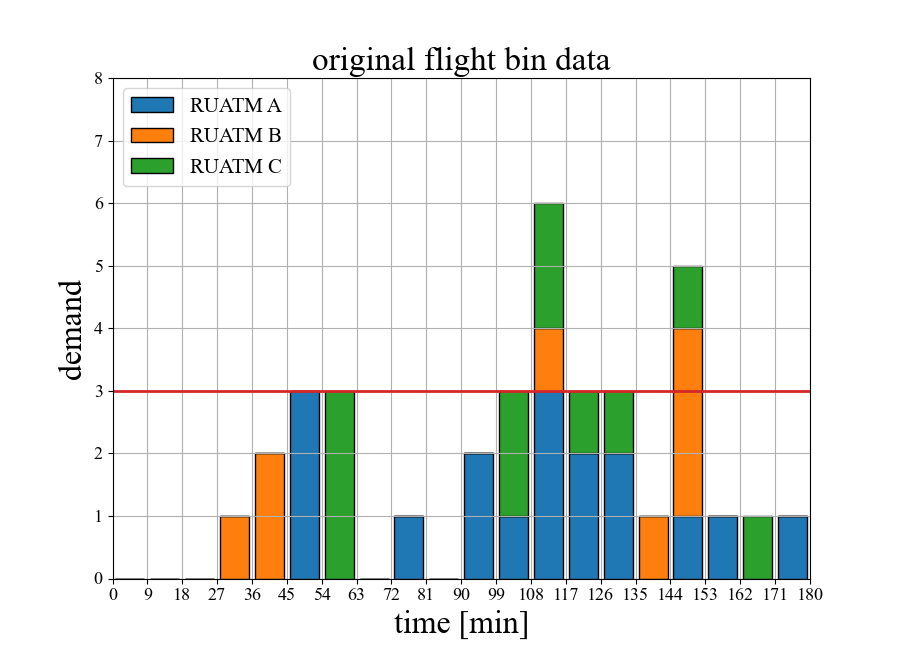

In [111]:
graph = Graph() #グラフ描画
#graph.vport(vport_ruatm_data, 'original flight', seed, save=False)
graph.vport_bin(vport_bin_data, 'original flight bin data', seed, sim_time, bin_size, save=False)

In [112]:
%%time
#DCB実行　Centralized

capa = 3
ruatm_id = np.array([0, 1, 2])
dcb = DCB(np.array([10, 10, 10, 10]))
delayed_fpl_data, delayed_bin_data = dcb.centralized_fcfs(ruatm_id, capa, sim_time, vport_bin_data, bin_size, fpl_data)

print(dcb.delay_memo)

3.0
3.0
3.0
1.0
3.0
1.0
[[   0.    0. 1661.   nan   nan   30.]
 [1707.    0.    0.   23.   nan   nan]
 [2915.    0.    0.    8.   nan   nan]
 [ 591.    0.    0.   10.   nan   nan]
 [   0. 1390.    0.   nan    4.   nan]]
CPU times: total: 57.6 s
Wall time: 57.5 s


In [9]:
%%time
#DCB実行　Cooperative

capa = 3
ruatm_id = np.array([0, 1, 2])
dcb = DCB(np.array([10, 10, 10, 10]))
delayed_fpl_data, delayed_bin_data = dcb.cooperative1_fcfs(ruatm_id, capa, route, sim_time, vport_bin_data, bin_size, fpl_data)

print(dcb.delay_memo)

    flight_id  dep  dep_time  route  arr_time
0           0    0      6065      0      7265
1           1    0      4638      0      5838
2           2    2      4642      7      7042
3           3    2      1291      7      3691
4           4    1      6469      4      8869
5           5    2      2101      6      3301
7           7    2      4864      6      6064
9           9    0      2374      1      4774
11         11    1      5780      4      8180
12         12    0      1763      0      2963
13         13    1      1285      3      2485
17         17    2      4305      7      6705
19         19    0      7186      1      9586
23         23    0      4532      1      6932
24         24    0      6888      0      8088
26         26    0       766      1      3166
27         27    0       315      1      2715
29         29    0      5873      0      7073
30         30    2      5778      6      6978
31         31    1       873      3      2073
32         32    1      1383      

In [11]:
%%time
#DCB実行　Distributed

capa = 1
dcb = DCB(np.array([10, 10, 10, 10]))

delayed_fpl_data_0, delayed_bin_data_0 = dcb.distributed_fcfs(0, capa, sim_time, vport_bin_data, bin_size, fpl_data)
print(dcb.delay_memo)
delayed_fpl_data_1, delayed_bin_data_1 = dcb.distributed_fcfs(1, capa, sim_time, vport_bin_data, bin_size, fpl_data)
print(dcb.delay_memo)
delayed_fpl_data_2, delayed_bin_data_2 = dcb.distributed_fcfs(2, capa, sim_time, vport_bin_data, bin_size, fpl_data)
print(dcb.delay_memo)

delayed_fpl_data_Dist = fpl_data.copy()
delayed_fpl_data_Dist = delayed_fpl_data_Dist.where(delayed_fpl_data_Dist["dep"] != 0, delayed_fpl_data_0)
delayed_fpl_data_Dist = delayed_fpl_data_Dist.where(delayed_fpl_data_Dist["dep"] != 1, delayed_fpl_data_1)
delayed_fpl_data_Dist = delayed_fpl_data_Dist.where(delayed_fpl_data_Dist["dep"] != 2, delayed_fpl_data_2)

delayed_ac = ArrCheck(delayed_fpl_data_Dist, ruatm_num, route, sim_time)
delayed_vport_flight_data, delayed_vport_ruatm_data = delayed_ac.flight(flight_num)
delayed_bin_data_Dist = delayed_ac.demand_calc(delayed_vport_ruatm_data, bin_size)


2.0


TypeError: ArrCheck.__init__() missing 1 required positional argument: 'sim_time'

<IPython.core.display.Javascript object>


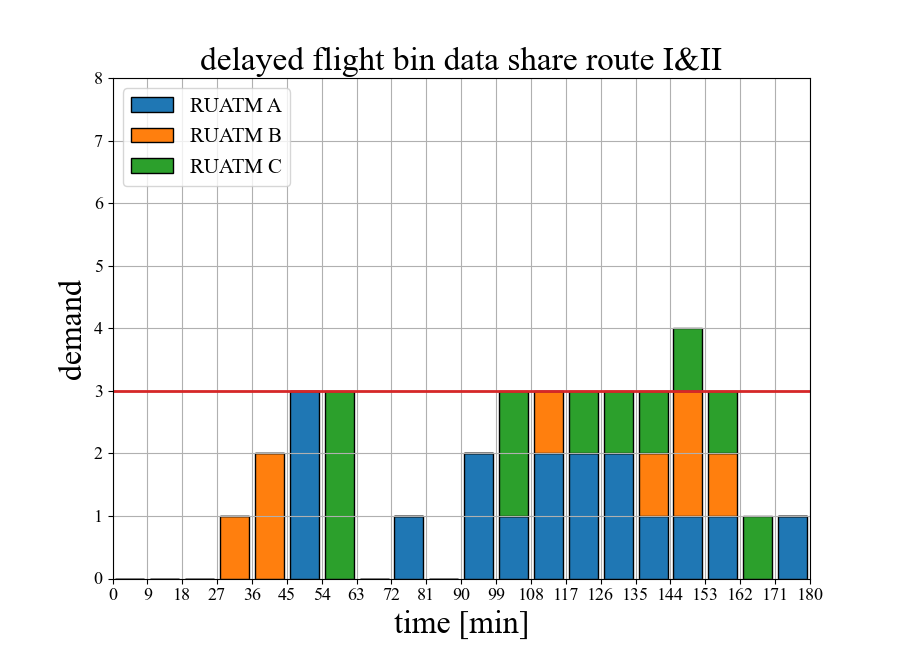

In [10]:
graph = Graph()
graph.vport_bin(delayed_bin_data, 'delayed flight bin data share route I&II', seed, sim_time, bin_size, save=True)

In [ ]:
#FPLデータの保存
original_csv = "data/original" + f"_{seed}" + f"_result_{datetime.now():%Y%m%d%H%M%S}.csv"
fpl_data.to_csv(original_csv)
flight_csv = "data/DCB" + f"_{seed}" + f"_result_{datetime.now():%Y%m%d%H%M%S}.csv"
delayed_fpl_data.to_csv(flight_csv)

In [92]:
a = pd.DataFrame([[1, 2, 3],[4, 5, 6], [7, 8, 9], [7, 11, 12]], columns=["dep", "arr", "mid"], index=[2, 4, 6, 8])

#print(a[a['dep'] == 1])
print(a)
#print(1 in a['dep'])
print(a.at[2, 'arr'])

   dep  arr  mid
2    1    2    3
4    4    5    6
6    7    8    9
8    7   11   12
2


In [95]:
b = pd.DataFrame([[100, 200, 300], [400, 500, 600]],  columns=["dep", "arr", "mid"], index=[2, 6])
print(b)
# self.fpl = self.fpl.where((self.fpl['route']!=0) | (self.fpl['route']!=3) | (self.fpl['route']!=6), self.cooperative_fpl)
a = a.where((a['mid']!=3) & (a['mid']!=9), b)

print(a)

   dep  arr  mid
2  100  200  300
6  400  500  600
   dep  arr  mid
2  100  200  300
4    4    5    6
6  400  500  600
8    7   11   12


In [14]:
aa = a[(a['arr'] == 2) | (a['arr'] == 5)]
print(aa)
aa.at[2, 'arr'] = 10
print(aa)

print(a.where(a['arr'] != 2, aa))

   dep  arr  mid
2    1    2    3
4    4    5    6
   dep  arr  mid
2    1   10    3
4    4    5    6
   dep  arr  mid
2    1   10    3
4    4    5    6
6    7    8    9
8    7   11   12


In [26]:
a = np.zeros((1,4))
print(a)
b = np.array([1, 2, 3, 4]).reshape(1, 4)
print(b)
a = np.append(a, b, axis=0)
print(a)
a = np.append(a, np.array([11, 12, 13, 14]).reshape(1, 4), axis=0)
a = np.append(a, np.array([111, 121, 131, 141]).reshape(1, 4), axis=0)
print(a)

[[0. 0. 0. 0.]]
[[1 2 3 4]]
[[0. 0. 0. 0.]
 [1. 2. 3. 4.]]
[[  0.   0.   0.   0.]
 [  1.   2.   3.   4.]
 [ 11.  12.  13.  14.]
 [111. 121. 131. 141.]]


In [12]:

a = np.zeros((0, 3))
print(len(a))
#print(np.max(a, axis=0)[0])

0


In [ ]:
a = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
b = np.array([0, 1, 2, 0, 1, 5, 0, 1, 2, 9])
c = np.array([0, 1, 2, 3, 1, 5, 0, 1, 2, 8])
d = np.where(a == b)
e = np.where(a == c)
g = np.where((a == c) & (a == b))
f = np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

print(d, e)
print(f[e and d], f[g])
#print(np.where(d != e))
d = np.array(d[0].T)
x = np.zeros((0,4))
#d = np.insert()
print(d)
for i in range(len(d)):
    x = np.append(x, np.array([[0, 0, 0, 0]]), axis=0)
    x[-1, 1] = d[i]
    
print(x)

In [ ]:
x[2] = x[3]
print(x)

In [ ]:
if x[1, :].any != 0:
    print('9')
    
print(x[1,:])

In [ ]:
a = np.zeros((0, 4))
b = np.append(a, np.array([[1, 2, 3, 0]]), axis=0)
print(b)

b[:, 2] = np.append(b[:, 2], 0)

print(b)

In [ ]:
a = np.zeros((3, 2, 4))
a = np.append(a, np.array([[[1, 2, 3, 4],[5, 6, 7, 8]]]), axis=0)
print(a)

In [ ]:
for i in [2, 4, 6]:
    print(i)
print(2 in [2, 3, 4, 5])

In [ ]:
print(list(range(108-1, -1, -1)))

In [ ]:
df = pd.DataFrame([[1, 2, 3, 4, 5, 6, 7, 8],
                  [10, 20, 30, 40, 50, 60, 70, 80],
                  [100, 200, 300, 400, 500, 600, 700, 800]], 
                         columns=["flight_id", "dep", "mid", "arr", "dep_time", "mid_time", "app_time", "arr_time"])
print(df["flight_id"])
print(any(10 == df["flight_id"]))

In [ ]:
dff = df[df["flight_id"] == 10]
print(int(dff["dep_time"]))